In [1]:

import re
import os
import math
import pickle
import random
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from transformers import BertForMaskedLM
from torch.utils.data import random_split
from dataloaders import random_collapse_per_path, PartialMergingTaxonomyDataset
from dataloaders import dataset_to_hf_dataset, TaxonomyPreCollator, create_taxonomy_data_collator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


device(type='cuda')

# load Data

In [2]:
# Adjust these paths as needed
taxonomy_matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-taxonomy-matrix.npz"
taxonomy_mapping_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/taxonomy_mapping.csv"

# Load the sparse (samples x taxonomies) matrix
X_taxonomy = sp.load_npz(taxonomy_matrix_path)
print("X_taxonomy shape:", X_taxonomy.shape)

# Load the mapping of columns -> taxonomy strings
df_tax_mapping = pd.read_csv(taxonomy_mapping_path)
taxonomy_list = df_tax_mapping["taxonomy"].tolist()

# print("Number of taxonomies:", len(taxonomy_list))
# print("First 5 taxonomies:", taxonomy_list[:5])


## dataloader
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/taxonomy_token_dictionary.pkl"
with open(output_path, "rb") as f:
    token_dict = pickle.load(f)
print("Loaded token dictionary with size:", len(token_dict))
do_augmentation=False
# Use your dynamic PyTorch dataset directly
partial_dataset = PartialMergingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    token_dict=token_dict,
    max_taxa=104,
    possible_ranks=('p','c','o','f','g','s'),
    do_augmentation=do_augmentation  # dynamic augmentation enabled
)

# Assume partial_dataset is your instance of PartialMergingTaxonomyDataset
total_samples = len(partial_dataset)
val_size = int(0.2 * total_samples)
train_size = total_samples - val_size


g = torch.Generator().manual_seed(123)
train_dataset, val_dataset = random_split(partial_dataset, [train_size, val_size], generator=g)

print(f"Total samples: {total_samples}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


X_taxonomy shape: (1836255, 8533)
Loaded token dictionary with size: 11318
Total samples: 1836255
Train samples: 1469004
Validation samples: 367251


#  Top Accuracy

In [3]:
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs"
epoch_to_test = 50  # we want the model at epoch 50
sample_index = 10   # we want to inspect sample 10 from the validation dataset

# Construct the checkpoint path for epoch 50.
# We assume the folder is named like "checkpoint-epoch50"
checkpoint_name = f"checkpoint-epoch{epoch_to_test}"
checkpoint_path = os.path.join(model_folder, checkpoint_name)

# ---------------------------
# Load the model from checkpoint for epoch 50
# ---------------------------
from transformers import BertForMaskedLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained(checkpoint_path)
model.to(device)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(11318, 256, padding_idx=0)
      (position_embeddings): Embedding(128, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise

In [4]:
from transformers import BatchEncoding

In [24]:
def test_model_on_val_samples_batched(
    model,
    val_dataset,
    collator,  # your DataCollatorForLanguageModeling
    token_dict,
    device,
    n=1000,
    batch_size=32,
    seed=123
):
    model.eval()
    model.to(device)

    random.seed(seed)
    selected_samples = [val_dataset[i] for i in random.sample(range(len(val_dataset)), n)]

    total_masked_tokens = 0
    correct_top1 = 0
    examples_list = []

    # Process samples in batches
    for start in range(0, n, batch_size):
        batch_samples = selected_samples[start:start + batch_size]

        # Use your training collator directly
        batch: BatchEncoding = collator(batch_samples)
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=batch["attention_mask"].to(device))
            logits = outputs.logits

        # Evaluate predictions
        for i in range(len(batch_samples)):
            sample_input_ids = input_ids[i]
            sample_labels = labels[i]
            sample_logits = logits[i]

            masked_positions = (sample_labels != -100).nonzero(as_tuple=True)[0]

            total_masked_tokens += len(masked_positions)
            for pos in masked_positions:
                true_token = sample_labels[pos].item()
                pred_token = torch.argmax(sample_logits[pos]).item()
                if pred_token == true_token:
                    correct_top1 += 1

            examples_list.append({
                "original_ids": batch_samples[i]["input_ids"],
                "masked_ids": sample_input_ids.cpu().tolist(),
                "masked_positions": masked_positions.cpu().tolist(),
                "original_tokens": [sample_labels[pos].item() if sample_labels[pos].item() != -100 else None 
                                    for pos in range(len(sample_labels))],
                "logits": sample_logits.cpu().tolist(),
                "sample_idx": start + i
            })

    overall_accuracy = correct_top1 / total_masked_tokens if total_masked_tokens else 0.0

    print(f"Total masked tokens evaluated: {total_masked_tokens}")
    print(f"Overall top-1 accuracy: {overall_accuracy:.4f}")

    return overall_accuracy, examples_list
collator = create_taxonomy_data_collator(token_dict)


In [ ]:
collator = create_taxonomy_data_collator(token_dict)

accuracy, examples_list = test_model_on_val_samples_batched(
    model=model,
    val_dataset=val_dataset,
    collator=collator,
    token_dict=token_dict,
    device=device,
    n=1000,
    batch_size=32,
    seed=42
)

Total masked tokens evaluated: 5453
Overall top-1 accuracy: 0.2312


In [185]:

id_to_str = {v: k for k, v in token_dict.items()}

sample_index = 10
sample = val_dataset[sample_index]

collator = create_taxonomy_data_collator(token_dict)
batch: BatchEncoding = collator([sample])

# Extract masked input_ids and labels
masked_ids = batch["input_ids"][0]
labels = batch["labels"][0]

# Positions masked (where labels are not -100)
masked_positions = (labels != -100).nonzero(as_tuple=True)[0].tolist()

# Run model inference on the masked sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

input_ids_tensor = masked_ids.unsqueeze(0).to(device)  # Add batch dimension
attention_mask_tensor = (input_ids_tensor != token_dict["<pad>"]).long()

with torch.no_grad():
    outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
    logits = outputs.logits  # [1, seq_len, vocab_size]

# Print detailed vertical inspection
original_ids = sample["input_ids"]

print("\n=== Detailed Sample Inspection (Sample index {}) ===".format(sample_index))
for pos in range(len(original_ids)):
    orig_tok = original_ids[pos]
    orig_str = id_to_str.get(orig_tok, "<unk>")

    if pos in masked_positions:
        true_label = labels[pos].item()
        true_label_str = id_to_str.get(true_label, "<unk>")

        token_logits = logits[0, pos]
        topk = torch.topk(token_logits, k=5)
        top_ids = topk.indices.tolist()
        top_values = topk.values.tolist()
        top_preds = [id_to_str.get(tid, "<unk>") for tid in top_ids]

        print(f"Position {pos}:")
        print(f"  Original Token: {orig_tok} => {orig_str} [MASKED]")
        print(f"  Label (true masked token): {true_label} => {true_label_str}")
        print("  Top-5 Predictions:")
        for rank, (pred_id, score, pred_str) in enumerate(zip(top_ids, top_values, top_preds), 1):
            print(f"    {rank}. {pred_id} => {pred_str}, logit: {score:.2f}")
    else:
        print(f"Position {pos}: {orig_tok} => {orig_str}")
        if orig_str == "<pad>":
            break



=== Detailed Sample Inspection (Sample index 10) ===
Position 0:
  Original Token: 2607 => d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium [MASKED]
  Label (true masked token): 2607 => d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium
  Top-5 Predictions:
    1. 2607 => d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium, logit: 20.05
    2. 6514 => d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus_A;s__Peptoniphilus_A, logit: 9.64
    3. 6481 => d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Helcococcaceae;g__Finegoldia;s__Finegoldia, logit: 7.48
    4. 5891 => d__Bacteria;p__Firmicutes_A;c__Clostridia, logit: 6.92
    5. 4127 => d__Bacteria;p__Campylobacterota;c__Campylobacteria;o__Campylobacte

In [ ]:

# def randomly_mask_sequence(
#     original_ids,
#     mask_token_id,
#     vocab_size,
#     mlm_probability=0.15,
#     mask_replace_prob=0.8,
#     random_replace_prob=0.1,
#     special_ids=None
# ):
#     """
#     Randomly mask ~mlm_probability fraction of NON-SPECIAL tokens in original_ids.
#     Returns:
#       masked_ids        : the new list of token IDs
#       masked_positions  : list of indices that got masked
#       original_tokens   : same length as masked_ids; only set at masked positions
#     """
#     if special_ids is None:
#         special_ids = set()
#     seq_length = len(original_ids)
#     masked_ids = original_ids[:]
#     masked_positions = []
#     original_tokens = [None]*seq_length
    
#     # 1) Decide which tokens to mask:
#     # only pick positions that are not in special_ids
#     candidate_positions = [
#         i for i, tok in enumerate(original_ids)
#         if tok not in special_ids
#     ]
#     # number of tokens to mask
#     num_to_mask = int(len(candidate_positions) * mlm_probability)
#     random.shuffle(candidate_positions)
#     chosen_positions = candidate_positions[:num_to_mask]
    
#     for pos in chosen_positions:
#         original_tok = original_ids[pos]
#         masked_positions.append(pos)
#         original_tokens[pos] = original_tok  # store the ground truth at pos

#         # now pick how we replace it:
#         r = random.random()
#         if r < mask_replace_prob:
#             # replace with <mask>
#             masked_ids[pos] = mask_token_id
#         elif r < mask_replace_prob + random_replace_prob:
#             # replace with a random ID
#             rnd_id = random.randint(0, vocab_size - 1)
#             masked_ids[pos] = rnd_id
#         else:
#             # keep original
#             masked_ids[pos] = original_tok
    
#     return masked_ids, masked_positions, original_tokens

# def test_model_on_val_samples_batched(
#     model,
#     val_dataset,
#     token_dict,
#     device,
#     n=100,
#     mlm_probability=0.15,
#     batch_size=32,
#     seed=123
# ):
#     """
#     Evaluate the model on up to 'n' random samples from val_dataset, using a batched approach.
    
#     Steps:
#       1. Select 'n' samples from val_dataset (randomly).
#       2. For each sample, apply random masking (~ mlm_probability) via randomly_mask_sequence.
#       3. Collect the masked sequences in a list.
#       4. Split that list into batches of 'batch_size'.
#       5. For each batch:
#          - Pad and convert to tensors (a minimal 'collator' step).
#          - Run a single forward pass to get logits.
#          - Compute top-1 accuracy for the masked positions in each sample.
    
#     Returns:
#       overall_accuracy: float   (top-1 masked token accuracy across all masked positions)
#       examples_list: list of dicts with info per sample:
#          - "original_ids":    the original token IDs
#          - "masked_ids":      the masked sequence
#          - "masked_positions": positions that were masked
#          - "original_tokens": ground-truth token IDs at those masked positions
#          - "logits":          a list-of-lists with shape [seq_len, vocab_size], 
#          - "sample_idx":      the index in val_dataset
#     """
#     # Make the model ready for inference
#     model.eval()
#     model.to(device)
    
#     # For reproducible sample selection
#     random.seed(seed)
    
#     # 1) Choose up to n random samples from val_dataset
#     indices = list(range(len(val_dataset)))
#     random.shuffle(indices)
#     chosen_indices = indices[:n]
    
#     pad_id = token_dict["<pad>"]
#     mask_id = token_dict["<mask>"]
#     vocab_size = len(token_dict)
    
#     # We'll skip special tokens from masking
#     special_ids = {pad_id, mask_id}
    
#     # 2) For each chosen sample, apply random masking
#     #    We'll store the results for later batching
#     all_masked_data = []  # each entry: (masked_ids, masked_positions, original_tokens, orig_ids, sample_idx)
    
#     total_samples_used = 0
#     for idx in chosen_indices:
#         row = val_dataset[idx]
#         original_ids = row["input_ids"]
        
#         masked_ids, masked_positions, original_tokens = randomly_mask_sequence(
#             original_ids,
#             mask_token_id=mask_id,
#             vocab_size=vocab_size,
#             mlm_probability=mlm_probability,
#             special_ids=special_ids
#         )
        
#         if len(masked_positions) == 0:
#             continue
        
#         # Save the masked data
#         all_masked_data.append((masked_ids, masked_positions, original_tokens, original_ids, idx))
#         total_samples_used += 1
    
#     if total_samples_used == 0:
#         return 0.0, []  # No masked tokens => accuracy = 0
    
#     # 3) Build results containers
#     total_masked_tokens = 0
#     correct_top1 = 0
#     examples_list = []
    
#     # 4) Split the masked data into mini-batches
#     num_batches = math.ceil(len(all_masked_data) / batch_size)
    
#     start_idx = 0
#     for b in range(num_batches):
#         batch_data = all_masked_data[start_idx : start_idx + batch_size]
#         start_idx += batch_size
        
#         # A) Collect masked sequences for this batch
#         batch_masked_ids   = [dat[0] for dat in batch_data]  # list of masked_id lists
#         batch_positions    = [dat[1] for dat in batch_data]
#         batch_orig_tokens  = [dat[2] for dat in batch_data]
#         batch_original_ids = [dat[3] for dat in batch_data]
#         batch_sample_idx   = [dat[4] for dat in batch_data]
        
#         # B) Pad them (manually or with a minimal collator)
#         max_len = max(len(seq) for seq in batch_masked_ids)
        
#         padded_input_ids = []
#         attention_masks  = []
#         for seq in batch_masked_ids:
#             pad_needed = max_len - len(seq)
#             padded_seq = seq + [pad_id]*pad_needed
#             padded_input_ids.append(padded_seq)
#             attn_mask = [1 if t != pad_id else 0 for t in padded_seq]
#             attention_masks.append(attn_mask)
        
#         # Convert to tensors
#         input_ids_tensor = torch.tensor(padded_input_ids, dtype=torch.long, device=device)
#         attention_mask_tensor = torch.tensor(attention_masks, dtype=torch.long, device=device)
        
#         # C) Forward pass
#         with torch.no_grad():
#             outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
#             logits_batch = outputs.logits  # shape: [batch_size, max_len, vocab_size]
        
#         # D) Evaluate top-1 accuracy for each sample in this batch
#         for i in range(len(batch_data)):
#             sample_logits = logits_batch[i]  # shape: [max_len, vocab_size]
#             masked_positions = batch_positions[i]
#             original_tokens  = batch_orig_tokens[i]
#             orig_ids         = batch_original_ids[i]
#             s_idx            = batch_sample_idx[i]
            
#             # Evaluate top-1
#             for pos in masked_positions:
#                 true_id = original_tokens[pos]
#                 if true_id is None:
#                     continue
#                 total_masked_tokens += 1
#                 pred_id = torch.argmax(sample_logits[pos]).item()
#                 if pred_id == true_id:
#                     correct_top1 += 1
            
#             # Store example info
#             example_info = {
#                 "original_ids":    orig_ids,
#                 "masked_ids":      batch_masked_ids[i],
#                 "masked_positions": masked_positions,
#                 "original_tokens":  original_tokens,
#                 # Because we padded, 'sample_logits' might have a shape bigger than original seq,
#                 # but the relevant positions are up to len(masked_ids). We'll store the entire CPU array for now.
#                 "logits": sample_logits.cpu().tolist(),
#                 "sample_idx": s_idx
#             }
#             examples_list.append(example_info)
    
#     # Final top-1 masked accuracy
#     overall_accuracy = correct_top1 / total_masked_tokens if total_masked_tokens > 0 else 0.0
    
#     return overall_accuracy, examples_list


In [8]:

def get_epoch_from_dir(dirname):
    match = re.search(r"(\d+)$", dirname)
    if match:
        return int(match.group(1))
    return -1

def get_checkpoint_data(model_folder, val_dataset, token_dict, device, batch_size, seed, n=1000, mlm_probability=0.15 ):
    # List all subdirectories starting with "checkpoint-epoch"
    checkpoints = [d for d in os.listdir(model_folder) if d.startswith("checkpoint-epoch")]
    # Sort checkpoints by epoch number
    checkpoints.sort(key=get_epoch_from_dir)

    epochs = []
    accuracies = []

    for ckpt_dir in checkpoints:
        ep = get_epoch_from_dir(ckpt_dir)
        checkpoint_path = os.path.join(model_folder, ckpt_dir)
        print(f"\n=== Loading checkpoint at epoch {ep}: {checkpoint_path} ===")
        
        # Load the model from the checkpoint
        model_ckpt = BertForMaskedLM.from_pretrained(checkpoint_path)
        model_ckpt.to(device)
        collator = create_taxonomy_data_collator(token_dict)
        
        # Evaluate top-1 masked accuracy on the validation dataset
        accuracy, _ = test_model_on_val_samples_batched(
            model=model_ckpt,
            val_dataset=val_dataset,
            collator=collator,
            token_dict=token_dict,
            device=device,
            n=n,
            batch_size=batch_size,
            seed=seed
        )
        epochs.append(ep)
        accuracies.append(accuracy)
        print(f"Epoch {ep} => Accuracy: {accuracy:.4f}")
    return epochs, accuracies


=== Loading checkpoint at epoch 1: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch1 ===
Total masked tokens evaluated: 579
Overall top-1 accuracy: 0.1623
Epoch 1 => Accuracy: 0.1623

=== Loading checkpoint at epoch 5: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch5 ===
Total masked tokens evaluated: 573
Overall top-1 accuracy: 0.1798
Epoch 5 => Accuracy: 0.1798

=== Loading checkpoint at epoch 10: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch10 ===
Total masked tokens evaluated: 532
Overall top-1 accuracy: 0.1880
Epoch 10 => Accuracy: 0.1880

=== Loading checkpoint at epoch 15: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch15 ===
T

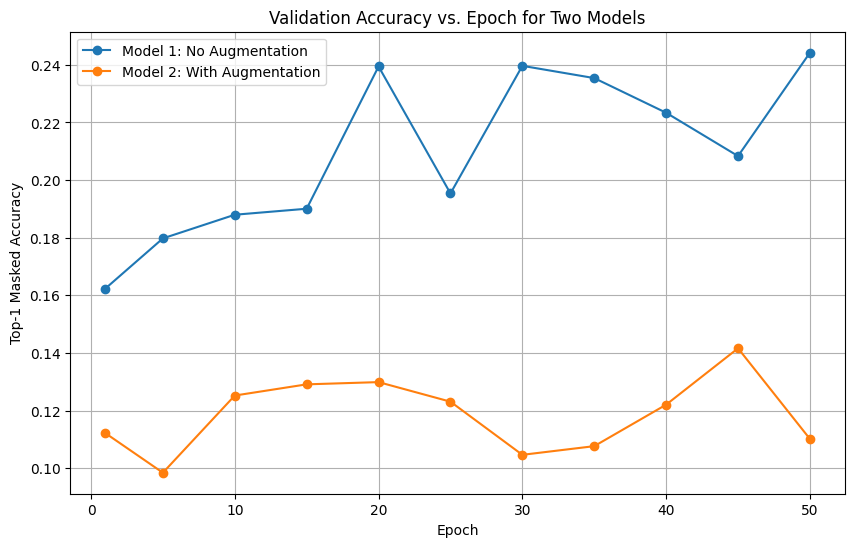

In [9]:
# Define the folders for the two models
model1_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs"
model2_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the checkpoints' epochs and corresponding accuracies for each model
epochs1, accuracies1 = get_checkpoint_data(model1_folder, val_dataset, token_dict, device, n=100, 
                                           mlm_probability=0.15, batch_size=256, seed=123)
epochs2, accuracies2 = get_checkpoint_data(model2_folder, val_dataset, token_dict, device, n=100, 
                                           mlm_probability=0.15,  batch_size=256, seed=123)

# Plot the results on the same figure
plt.figure(figsize=(10, 6))
plt.plot(epochs1, accuracies1, marker='o', label="Model 1: No Augmentation")
plt.plot(epochs2, accuracies2, marker='o', label="Model 2: With Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Top-1 Masked Accuracy")
plt.title("Validation Accuracy vs. Epoch for Two Models")
plt.legend()
plt.grid(True)
plt.show()

# Repetition metrics 

In [25]:
def compute_top1_repetition_metric(examples_list):
    """
    For each sample in examples_list, compute the fraction of masked positions where
    the top-1 prediction is repeated in the sample (i.e. the same prediction occurs in more
    than one masked position).

    For a given sample:
      Let m = number of masked positions.
      Let U = number of unique top-1 predictions at masked positions.
      Then we define the repetition fraction as (m - U) / m.

    Returns a dictionary with:
        - "per_sample_repetition": list of repetition fractions per sample,
        - "mean_repetition": overall mean of these fractions,
        - "std_repetition": standard deviation,
        - "total_masked": total number of masked positions evaluated,
        - "total_repeated": total number of repeated predictions (i.e. sum over samples of (m - U)).
    """
    per_sample_repetition = []
    total_masked = 0
    total_repeated = 0
    
    for sample in examples_list:
        masked_positions = sample["masked_positions"]  # indices that were masked
        logits_matrix = sample["logits"]  # list of lists, shape: [seq_len, vocab_size]
        
        # For each masked position, compute top-1 prediction.
        top1_predictions = []
        for pos in masked_positions:
            # Convert logits at this position to a torch tensor and get the index with max logit.
            token_logits = torch.tensor(logits_matrix[pos])
            top1 = torch.argmax(token_logits).item()
            top1_predictions.append(top1)
        
        m = len(top1_predictions)
        if m == 0:
            fraction = 0.0
        else:
            unique_preds = len(set(top1_predictions))
            repeated_in_sample = m - unique_preds  # number of repetitions in this sample
            fraction = repeated_in_sample / m
            total_masked += m
            total_repeated += repeated_in_sample
        
        per_sample_repetition.append(fraction)
    
    if per_sample_repetition:
        mean_repetition = np.mean(per_sample_repetition)
        std_repetition = np.std(per_sample_repetition)
    else:
        mean_repetition = 0.0
        std_repetition = 0.0

    return {
        "per_sample_repetition": per_sample_repetition,
        "mean_repetition": mean_repetition,
        "std_repetition": std_repetition,
        "total_masked": total_masked,
        "total_repeated": total_repeated,
    }

def compute_repetition_metric(examples_list, token_dict):
    """
    For each sample in examples_list, compute the fraction of masked positions where the
    top-1 predicted token is already present in the context (non-masked positions).
    
    Args:
        examples_list: list of dicts, each with keys:
            - "original_ids": list of int (the original sequence of token IDs)
            - "masked_positions": list of int (indices that were masked)
            - "logits": a list-of-lists with shape [seq_len, vocab_size]
        token_dict: dictionary mapping tokens (str) to token IDs (int)
    
    Returns a dictionary with:
        - "per_sample_fractions": list of repetition fractions per sample,
        - "mean_fraction": overall mean of these fractions,
        - "std_fraction": standard deviation,
        - "total_masked": total number of masked positions evaluated,
        - "total_repeated": total count of masked positions where prediction is in context.
    """
    repetition_fractions = []
    repeated_counts = []
    total_masked_counts = []
    
    for sample in examples_list:
        orig_ids = sample["original_ids"]          # e.g., [t1, t2, ..., tN]
        masked_positions = sample["masked_positions"]  # indices where masking was applied
        logits_matrix = sample["logits"]             # list of lists: shape [seq_len, vocab_size]
        
        # Convert logits matrix to a torch tensor for ease
        logits_tensor = torch.tensor(logits_matrix)
        
        # Define context as the indices that were NOT masked.
        context_indices = set(range(len(orig_ids))) - set(masked_positions)
        context_tokens = [orig_ids[i] for i in context_indices]
        
        sample_repeated = 0  # count how many masked positions have predictions already in context
        sample_total = len(masked_positions)
        
        for pos in masked_positions:
            # For each masked position, get top-1 prediction.
            top1 = torch.argmax(logits_tensor[pos]).item()
            if top1 in context_tokens:
                sample_repeated += 1
        
        if sample_total > 0:
            fraction = sample_repeated / sample_total
            repetition_fractions.append(fraction)
            repeated_counts.append(sample_repeated)
            total_masked_counts.append(sample_total)
    
    if repetition_fractions:
        mean_fraction = np.mean(repetition_fractions)
        std_fraction = np.std(repetition_fractions)
    else:
        mean_fraction = 0.0
        std_fraction = 0.0
        
    return {
        "per_sample_fractions": repetition_fractions,
        "mean_fraction": mean_fraction,
        "std_fraction": std_fraction,
        "total_masked": sum(total_masked_counts),
        "total_repeated": sum(repeated_counts)
    }




In [15]:
# Quick sanity test
test_examples = [
    {"masked_positions": [0, 1, 2], "logits": [[0,10,1], [0,9,1], [0,8,1]]}, # All predictions identical (id=1)
    {"masked_positions": [0, 1, 2], "logits": [[10,0,1], [0,10,1], [0,0,10]]}, # All unique predictions
]

result = compute_top1_repetition_metric(test_examples)
print(result)

{'per_sample_repetition': [0.6666666666666666, 0.0], 'mean_repetition': np.float64(0.3333333333333333), 'std_repetition': np.float64(0.3333333333333333), 'total_masked': 6, 'total_repeated': 2}


In [26]:
def taxonomy_distance(tax1: str, tax2: str) -> int:
    """
    Compute the distance between two taxonomy strings by comparing
    their common prefix (split by ';').
    distance = (len(ranks1) - prefix_len) + (len(ranks2) - prefix_len)
    """
    ranks1 = tax1.split(";")
    ranks2 = tax2.split(";")
    prefix_len = 0
    for a, b in zip(ranks1, ranks2):
        if a == b:
            prefix_len += 1
        else:
            break
    dist = (len(ranks1) - prefix_len) + (len(ranks2) - prefix_len)
    return dist

In [27]:
def compute_tax_distance_metric(examples_list, token_dict):
    """
    For each masked token in `examples_list`, compute the tree distance
    between the real taxonomy and the model's top-1 predicted taxonomy.
    
    Returns a dictionary with:
       - "mean_distance": mean distance across all masked tokens
       - "std_distance":  std dev of the distance
       - "total_masked":  total count of masked tokens
    """
   
    # Build inverse dictionary: token ID -> taxonomy string
    id_to_str = {v: k for k, v in token_dict.items()}
    
    distances = []
    
    total_masked = 0
    for sample in examples_list:
        masked_positions = sample["masked_positions"]
        logits_matrix = sample["logits"]  # shape [seq_len, vocab_size]
        original_tokens = sample["original_tokens"]  # ground truth for each masked position
        # Convert to torch tensor for easy argmax
        import torch
        logits_tensor = torch.tensor(logits_matrix)
        
        for pos in masked_positions:
            real_id = original_tokens[pos]
            if real_id is None:
                continue
            total_masked += 1
            
            # Real taxonomy
            real_tax = id_to_str.get(real_id)
            
            # Predicted taxonomy
            pred_id = torch.argmax(logits_tensor[pos]).item()
            pred_tax = id_to_str.get(pred_id)
            
            dist = taxonomy_distance(real_tax, pred_tax)
            distances.append(dist)
    
    if not distances:
        return {
            "mean_distance": 0.0,
            "std_distance": 0.0,
            "total_masked": 0
        }
    else:
        mean_dist = float(np.mean(distances))
        std_dist  = float(np.std(distances))
        return {
            "mean_distance": mean_dist,
            "std_distance": std_dist,
            "total_masked": total_masked
        }


In [33]:
def get_epoch_from_dir(dirname):
    """Extracts the integer epoch from a folder name like 'checkpoint-epoch5'."""
    match = re.search(r"(\d+)$", dirname)
    if match:
        return int(match.group(1))
    return -1


def get_checkpoint_data_with_repetition(model_folder, val_dataset, token_dict, device, n=1000, mlm_probability=0.15):
    """
    For each checkpoint subfolder in model_folder (e.g., 'checkpoint-epoch5'),
    load the model, evaluate it on n random validation samples (using test_model_on_val_samples),
    and compute:
      - top-1 masked accuracy,
      - repetition metric: fraction of masked tokens whose top-1 prediction is already present in the context.
    Returns:
      epochs, accuracies, repetition_means, repetition_stds
    """
    # List all checkpoint subfolders
    checkpoints = [d for d in os.listdir(model_folder) if d.startswith("checkpoint-epoch")]
    # Sort them by epoch
    checkpoints.sort(key=get_epoch_from_dir)

    epochs = []
    accuracies = []
    rep_means = []
    rep_stds = []
    rep_top_mean = []
    rep_top_stds = []

    for d in checkpoints:
        ep = get_epoch_from_dir(d)
        checkpoint_path = os.path.join(model_folder, d)
        print(f"\n=== Loading checkpoint at epoch {ep}: {checkpoint_path} ===")
        
        # Load the model checkpoint
        model_ckpt = BertForMaskedLM.from_pretrained(checkpoint_path)
        model_ckpt.to(device)
        
        accuracy, examples_list = test_model_on_val_samples_batched(
            model=model_ckpt,
            val_dataset=val_dataset,
            collator=collator,
            token_dict=token_dict,
            device=device,
            n=n,
            batch_size=512,
            seed=123
        )
        
        # Compute the repetition metric on the returned examples
        rep_metrics = compute_repetition_metric(examples_list, token_dict)
        rep_top_metric = compute_top1_repetition_metric(examples_list)
        
        epochs.append(ep)
        accuracies.append(accuracy)
        rep_means.append(rep_metrics["mean_fraction"])
        rep_stds.append(rep_metrics["std_fraction"])
        rep_top_mean.append(rep_top_metric["mean_repetition"])
        rep_top_stds.append(rep_top_metric["std_repetition"])
        
        print(f"Epoch {ep}: Accuracy = {accuracy:.4f}, Top 1 repetition = {rep_top_metric['mean_repetition']:.4f}")
    
    return epochs, accuracies, rep_means, rep_stds, rep_top_mean, rep_top_stds


In [40]:
# --- Define model folders for two models ---
model1_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs_no_randon_replace"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Get checkpoint data for each model ---
epochs1, accuracies1, rep_means1, rep_stds1, rep_top_mean1, rep_top_stds1  = get_checkpoint_data_with_repetition(
    model_folder=model1_folder,
    val_dataset=val_dataset,
    token_dict=token_dict,
    device=device,
    n=100,
    mlm_probability=0.15)


=== Loading checkpoint at epoch 1: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs_no_randon_replace/checkpoint-epoch1 ===
Total masked tokens evaluated: 550
Overall top-1 accuracy: 0.0400
Epoch 1: Accuracy = 0.0400, Top 1 repetition = 0.3958

=== Loading checkpoint at epoch 5: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs_no_randon_replace/checkpoint-epoch5 ===
Total masked tokens evaluated: 552
Overall top-1 accuracy: 0.0598
Epoch 5: Accuracy = 0.0598, Top 1 repetition = 0.3890

=== Loading checkpoint at epoch 10: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs_no_randon_replace/checkpoint-epoch10 ===
Total masked tokens evaluated: 564
Overall top-1 accuracy: 0.0798
Epoch 10: Accuracy = 0.0798, Top 1 repetition = 0.4293

=== Loading checkpoint at epoch 15: /home/hernan

In [34]:
# --- Define model folders for two models ---
model1_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs"
model2_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Get checkpoint data for each model ---
epochs1, accuracies1, rep_means1, rep_stds1, rep_top_mean1, rep_top_stds1  = get_checkpoint_data_with_repetition(
    model_folder=model1_folder,
    val_dataset=val_dataset,
    token_dict=token_dict,
    device=device,
    n=100,
    mlm_probability=0.15
)
model2_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs"

epochs2, accuracies2, rep_means2, rep_stds2, rep_top_mean2, rep_top_stds2 = get_checkpoint_data_with_repetition(
    model_folder=model2_folder,
    val_dataset=val_dataset,
    token_dict=token_dict,
    device=device,
    n=100,
    mlm_probability=0.15
)



=== Loading checkpoint at epoch 1: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch1 ===
Total masked tokens evaluated: 550
Overall top-1 accuracy: 0.1691
Epoch 1: Accuracy = 0.1691, Top 1 repetition = 0.3972

=== Loading checkpoint at epoch 5: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch5 ===
Total masked tokens evaluated: 590
Overall top-1 accuracy: 0.1864
Epoch 5: Accuracy = 0.1864, Top 1 repetition = 0.4351

=== Loading checkpoint at epoch 10: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch10 ===
Total masked tokens evaluated: 568
Overall top-1 accuracy: 0.2007
Epoch 10: Accuracy = 0.2007, Top 1 repetition = 0.4155

=== Loading checkpoint at epoch 15: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/

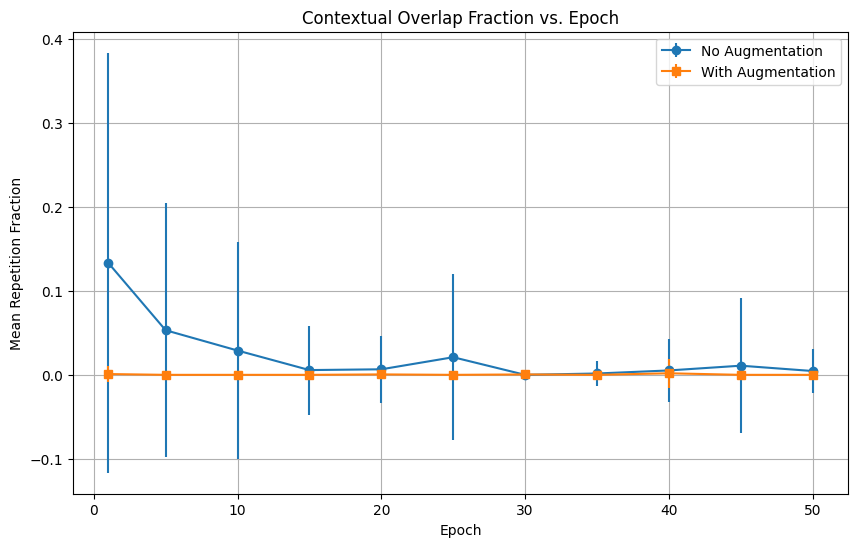

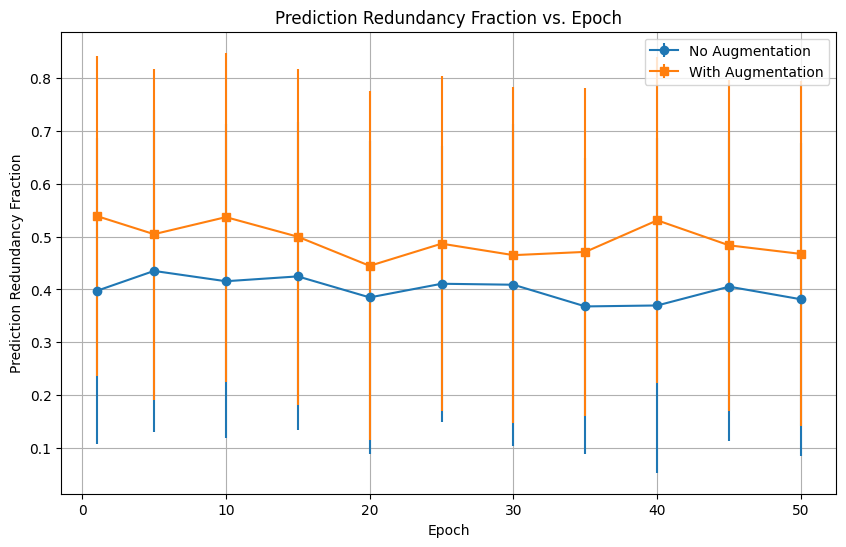

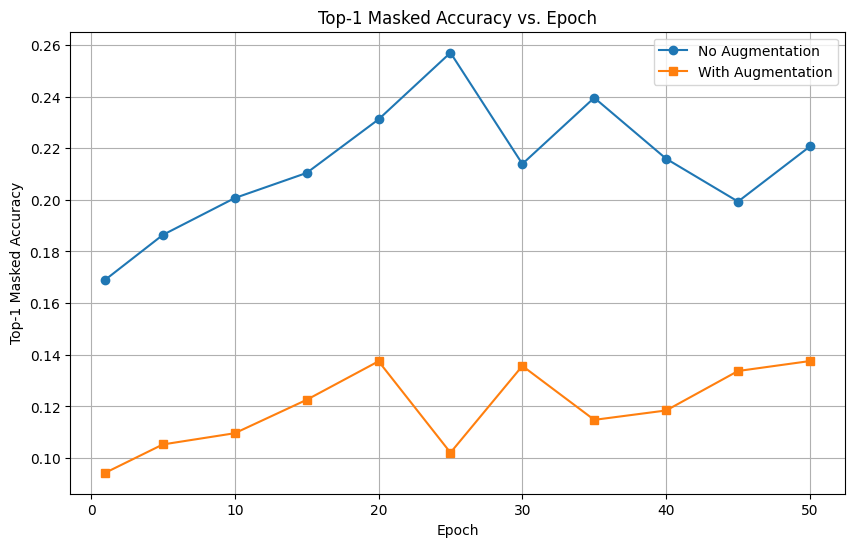

In [35]:

# --- Plot Repetition Metric for Both Models ---
plt.figure(figsize=(10,6))
plt.errorbar(epochs1, rep_means1, yerr=rep_stds1, fmt='o-', label="No Augmentation")
plt.errorbar(epochs2, rep_means2, yerr=rep_stds2, fmt='s-', label="With Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Mean Repetition Fraction")
plt.title("Contextual Overlap Fraction vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot top 1 Repetition Metric for Both Models ---
plt.figure(figsize=(10,6))
plt.errorbar(epochs1, rep_top_mean1, yerr=rep_top_stds1, fmt='o-', label="No Augmentation")
plt.errorbar(epochs2, rep_top_mean2, yerr=rep_top_stds2, fmt='s-', label="With Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Prediction Redundancy Fraction")
plt.title("Prediction Redundancy Fraction vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()



# --- Plot Top-1 Accuracy for Both Models ---
plt.figure(figsize=(10,6))
plt.plot(epochs1, accuracies1, marker='o', label="No Augmentation")
plt.plot(epochs2, accuracies2, marker='s', label="With Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Top-1 Masked Accuracy")
plt.title("Top-1 Masked Accuracy vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs"
epoch_to_test = 50  # we want the model at epoch 50
sample_index = 10   # we want to inspect sample 10 from the validation dataset

# Construct the checkpoint path for epoch 50.
# We assume the folder is named like "checkpoint-epoch50"
checkpoint_name = f"checkpoint-epoch{epoch_to_test}"
checkpoint_path = os.path.join(model_folder, checkpoint_name)

# ---------------------------
# Load the model from checkpoint for epoch 50
# ---------------------------
from transformers import BertForMaskedLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained(checkpoint_path)
model.to(device)
model.eval()
print(f"Loaded model from: {checkpoint_path}")

Loaded model from: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch50


In [37]:

id_to_str = {v: k for k, v in token_dict.items()}

sample_index = 10
sample = val_dataset[sample_index]

collator = create_taxonomy_data_collator(token_dict)
batch: BatchEncoding = collator([sample])

# Extract masked input_ids and labels
masked_ids = batch["input_ids"][0]
labels = batch["labels"][0]

# Positions masked (where labels are not -100)
masked_positions = (labels != -100).nonzero(as_tuple=True)[0].tolist()

# Run model inference on the masked sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

input_ids_tensor = masked_ids.unsqueeze(0).to(device)  # Add batch dimension
attention_mask_tensor = (input_ids_tensor != token_dict["<pad>"]).long()

with torch.no_grad():
    outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
    logits = outputs.logits  # [1, seq_len, vocab_size]

# Print detailed vertical inspection
original_ids = sample["input_ids"]

print("\n=== Detailed Sample Inspection (Sample index {}) ===".format(sample_index))
for pos in range(len(original_ids)):
    orig_tok = original_ids[pos]
    orig_str = id_to_str.get(orig_tok, "<unk>")

    if pos in masked_positions:
        true_label = labels[pos].item()
        true_label_str = id_to_str.get(true_label, "<unk>")

        token_logits = logits[0, pos]
        topk = torch.topk(token_logits, k=5)
        top_ids = topk.indices.tolist()
        top_values = topk.values.tolist()
        top_preds = [id_to_str.get(tid, "<unk>") for tid in top_ids]

        print(f"Position {pos}:")
        print(f"  Original Token: {orig_tok} => {orig_str} [MASKED]")
        print(f"  Label (true masked token): {true_label} => {true_label_str}")
        print("  Top-5 Predictions:")
        for rank, (pred_id, score, pred_str) in enumerate(zip(top_ids, top_values, top_preds), 1):
            print(f"    {rank}. {pred_id} => {pred_str}, logit: {score:.2f}")
    else:
        print(f"Position {pos}: {orig_tok} => {orig_str}")
        if orig_str == "<pad>":
            break



=== Detailed Sample Inspection (Sample index 10) ===
Position 0: 2607 => d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium
Position 1:
  Original Token: 6481 => d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Helcococcaceae;g__Finegoldia;s__Finegoldia [MASKED]
  Label (true masked token): 6481 => d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Helcococcaceae;g__Finegoldia;s__Finegoldia
  Top-5 Predictions:
    1. 6481 => d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Helcococcaceae;g__Finegoldia;s__Finegoldia, logit: 19.06
    2. 2741 => d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Cutibacterium;s__Cutibacterium, logit: 14.44
    3. 5792 => d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus, logit: 11.92
    4. 5885 => d__Bacteria;p__Firmicutes;c__Baci

In [34]:
sample_index = 10  # or any sample of interest
sample = val_dataset[sample_index]
original_ids = sample["input_ids"]
masked_ids, masked_positions, original_tokens = randomly_mask_sequence(
    original_ids,
    mask_token_id=token_dict["<mask>"],
    vocab_size=len(token_dict),
    mlm_probability=0.15,
    mask_replace_prob=0.8,
    random_replace_prob=0.1,
    special_ids={token_dict["<pad>"], token_dict["<mask>"]}
)
print("Original IDs:", original_ids)
print("Masked IDs:", masked_ids)
print("Masked Positions:", masked_positions)


Original IDs: [2607, 6481, 715, 3128, 6479, 5734, 6514, 5884, 5885, 2606, 6812, 3223, 2228, 2540, 6518, 2741, 6447, 2373, 6489, 6522, 4127, 6798, 3108, 2615, 6480, 6469, 2315, 5295, 6424, 2303, 2384, 2309, 6905, 2852, 6478, 9263, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Masked IDs: [2607, 6481, 1, 3128, 1, 5734, 6514, 5884, 5885, 1, 6812, 3223, 2228, 2540, 6518, 2741, 6447, 2373, 6489, 6522, 4127, 6798, 3108, 1, 6480, 6469, 2315, 5295, 6424, 8250, 2384, 2309, 6905, 2852, 6478, 9263, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Masked Positions: [4, 2, 9, 23, 29]


In [ ]:
input_ids_tensor = torch.tensor([masked_ids], dtype=torch.long, device=device)
attention_mask_tensor = (input_ids_tensor != token_dict["<pad>"]).long()

In [71]:
# (Optional) Ensure reproducibility for dataset sampling
random.seed(123)

# Evaluate the model on 1000 samples from the validation dataset.
# Here we assume that test_model_on_val_samples_batched is already defined.
accuracy, examples_list = test_model_on_val_samples_batched(
    model=model,
    val_dataset=val_dataset,
    token_dict=token_dict,
    device=device,
    n=1000,               # Use 1000 samples for evaluation
    mlm_probability=0.15,
    batch_size=32,
    seed=123
)

print(f"Overall top-1 accuracy on masked tokens for 1000 samples: {accuracy:.4f}")

# Build inverse dictionary if not already defined.
# This maps token id back to token string for printing.
id_to_str = {v: k for k, v in token_dict.items()}


Overall top-1 accuracy on masked tokens for 1000 samples: 0.2463


In [77]:
examples_list[0].keys()

dict_keys(['original_ids', 'masked_ids', 'masked_positions', 'original_tokens', 'logits', 'sample_idx'])

In [81]:
sample_idxs = []
for i in examples_list:
    sample_idxs.append(i["sample_idx"])



print("Sample indices:", sample_idxs)

Sample indices: [216615, 89576, 226277, 339538, 102675, 125571, 54379, 95199, 230706, 151555, 14842, 135065, 276298, 41675, 17487, 239465, 230082, 22353, 273370, 244521, 348190, 10055, 252532, 28978, 318641, 335168, 179340, 296082, 148384, 138798, 49056, 20188, 193902, 88179, 167371, 359369, 185172, 103262, 113965, 346462, 295457, 165812, 143834, 84371, 41695, 312174, 32550, 190592, 22359, 73972, 205637, 250513, 209344, 149746, 261233, 264866, 239000, 242600, 185706, 67825, 337252, 256518, 281891, 231599, 169424, 273567, 89167, 313210, 6369, 365789, 238839, 188485, 214699, 192295, 147310, 35120, 83084, 184580, 174174, 57602, 238562, 34928, 304230, 200567, 202610, 225946, 100040, 165208, 21269, 24959, 184092, 237377, 345865, 277734, 80519, 197557, 226367, 25425, 114602, 22872, 279543, 93219, 179025, 350820, 201945, 192296, 175231, 227187, 139936, 311770, 26505, 142644, 236000, 285594, 198507, 128807, 166488, 310674, 83369, 22129, 196981, 76721, 290918, 15728, 67936, 185353, 10864, 32615

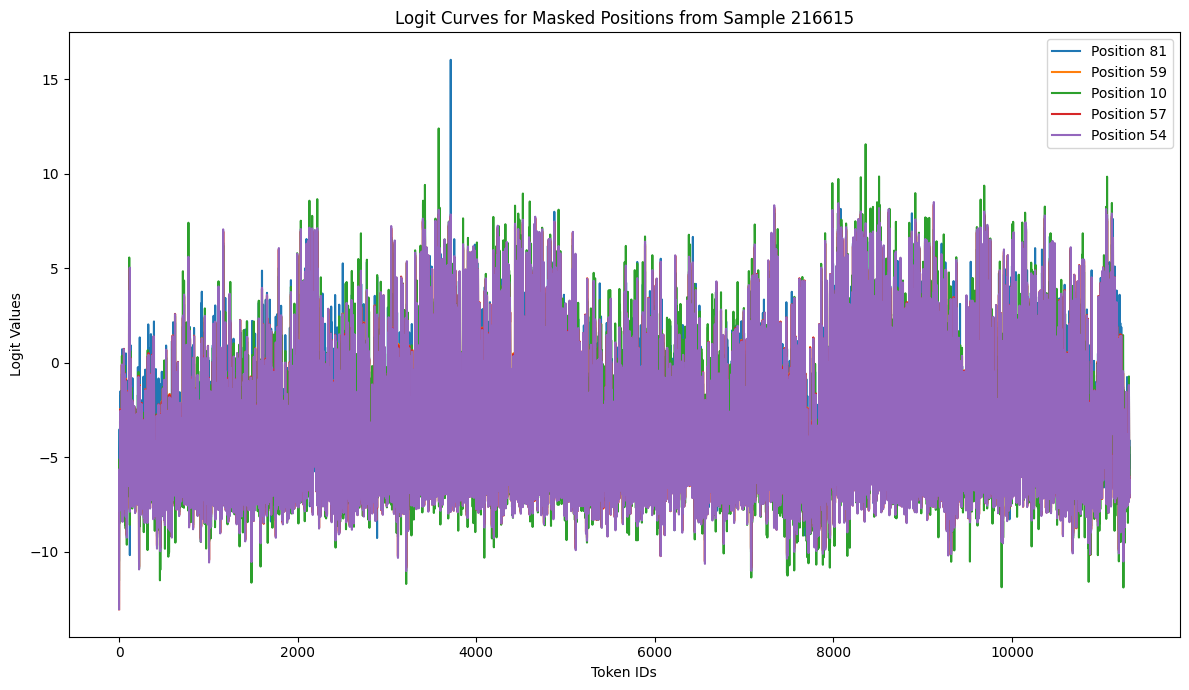


=== Detailed Sample Inspection (Sample index 216615) ===
Position 0: 10014 => d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Immundisolibacterales
Position 1: 8144 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria
Position 2: 8047 => d__Bacteria;p__Planctomycetota;c__Planctomycetes;o__Pirellulales
Position 3: 8049 => d__Bacteria;p__Planctomycetota;c__Planctomycetes;o__Pirellulales;f__Pirellulaceae
Position 4: 8532 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae
Position 5: 8325 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Kiloniellales;f__Fodinicurvataceae
Position 6: 9156 => d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria
Position 7: 4436 => d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia
Position 8: 8620 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Stappiaceae;g__Labrenzia
Position 9: 8680 => d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae


In [99]:
# === User parameters ===
# Specify which sample (by sample index from your evaluation function) you want to visualize.
selected_sample_idx = 216615  # Change this value as desired.
# Define how many masked positions you want to plot from the chosen sample.
num_positions_to_plot = 5

# === Select the sample from your examples_list ===
# Here we assume that each example in examples_list contains a field "sample_idx" and other required fields.
selected_sample = None
for ex in examples_list:
    if ex["sample_idx"] == selected_sample_idx:
        selected_sample = ex


if selected_sample is None:
    raise ValueError(f"Sample with index {selected_sample_idx} not found in examples_list.")

# === Plotting the logit curves for the selected sample ===
# Extract up to 'num_positions_to_plot' masked positions from the sample.
positions_to_plot = selected_sample["masked_positions"][:num_positions_to_plot]

plt.figure(figsize=(12, 7))
for pos in positions_to_plot:
    # Retrieve the logit vector for that position (assumed to have length equal to the vocabulary size)
    logits_vector = np.array(selected_sample["logits"][pos])
    # Create an array for the x-axis representing token IDs
    token_ids = np.arange(len(logits_vector))
    # Plot the logit curve.
    plt.plot(token_ids, logits_vector, label=f"Position {pos}")

plt.xlabel("Token IDs")
plt.ylabel("Logit Values")
plt.title(f"Logit Curves for Masked Positions from Sample {selected_sample_idx}")
plt.legend()
plt.tight_layout()
plt.show()



# === Detailed Vertical Printout of the Entire Sequence ===
print("\n=== Detailed Sample Inspection (Sample index {}) ===".format(selected_sample["sample_idx"]))
# Iterate over the entire sequence
for pos in range(len(selected_sample["original_ids"])):
    # Get the original token ID and its corresponding taxonomy string.
    orig_tok = selected_sample["original_ids"][pos]
    orig_str = id_to_str.get(orig_tok, "<unk>")
    
    # If the current position is among the masked ones, print predictions.
    if pos in selected_sample["masked_positions"]:
        # Convert the logits vector for this position to a tensor.
        token_logits = torch.tensor(selected_sample["logits"][pos])
        # Get top-5 predictions.
        topk = torch.topk(token_logits, k=5)
        top_ids = topk.indices.tolist()
        top_values = topk.values.tolist()
        top_preds = [id_to_str.get(tid, "<unk>") for tid in top_ids]
        
        print(f"Position {pos}:")
        print(f"  Original Token: {orig_tok} => {orig_str}  [MASKED]")
        print("  Top-5 Predictions:")
        for rank, (pred_id, score, pred_str) in enumerate(zip(top_ids, top_values, top_preds), start=1):
            print(f"    {rank}. {pred_id} => {pred_str}, logit: {score:.2f}")
    else:
        # Otherwise, print the unmasked token.
        print(f"Position {pos}: {orig_tok} => {orig_str}")
        # If we hit a padding token, we assume the rest is just padding and break.
        if orig_str == "<pad>":
            break

In [95]:
from collections import Counter


In [98]:
sample_prediction_counts

[Counter({9126: 5, 3580: 5, 3715: 1, 8056: 1, 9690: 1}),
 Counter({2865: 4}),
 Counter({715: 2, 9263: 1}),
 Counter({5792: 1}),
 Counter({8432: 3, 11046: 1, 2728: 1}),
 Counter({6314: 1}),
 Counter({6363: 1}),
 Counter({3048: 8, 9156: 3, 3377: 2, 11033: 1, 1688: 1}),
 Counter({6292: 2, 6216: 1}),
 Counter({8360: 5, 8049: 1}),
 Counter({2228: 5, 5668: 1, 8585: 1}),
 Counter({7564: 1, 8655: 1}),
 Counter({6244: 4, 6292: 2, 3107: 2, 6079: 1, 6188: 1, 5615: 1, 5953: 1}),
 Counter({3107: 1, 1288: 1}),
 Counter({5850: 6, 6290: 6, 6245: 2, 6079: 1}),
 Counter({7060: 1, 3107: 1, 6314: 1}),
 Counter({2062: 1}),
 Counter({6805: 8, 6800: 4, 5791: 1}),
 Counter({6358: 4, 9429: 1}),
 Counter({6798: 1, 6469: 1, 2305: 1}),
 Counter({3048: 2, 3377: 2, 7988: 1}),
 Counter({6246: 5, 6314: 2}),
 Counter({9263: 2, 10290: 1, 8033: 1}),
 Counter({6314: 4, 6288: 1}),
 Counter({6358: 4, 1490: 3, 5950: 1}),
 Counter({2793: 3}),
 Counter({3196: 1}),
 Counter({3242: 2, 3202: 2, 6245: 1}),
 Counter({7070: 4, 6079

In [117]:
sample_prediction_counts = []

# Global counter: but we'll add counts only if a token is repeated (i.e. count > 1) in a sample.
# Loop through each sample in the examples_list.
for ex in examples_list:
    sample_counter = Counter()
    # Loop over each masked position in the sample.
    for pos in ex["masked_positions"]:
        # Retrieve the logits for this position, assumed as a list of length equal to the vocabulary size.
        token_logits = torch.tensor(ex["logits"][pos])
        # Get the top-1 prediction.
        pred_id = int(torch.argmax(token_logits).item())
        sample_counter[pred_id] += 1
    # Save the per-sample counter.
    sample_prediction_counts.append(sample_counter)

global_counter = Counter()

for sample_counter in sample_prediction_counts:
    # For each token in this sample's counter:
    for token_id, freq in sample_counter.items():
        # Only add if it was repeated (>1) in this sample:
        if freq > 1:
            global_counter[token_id] += 1


In [120]:
len(global_counter)

414

/tmp/ipykernel_2315383/1688314715.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


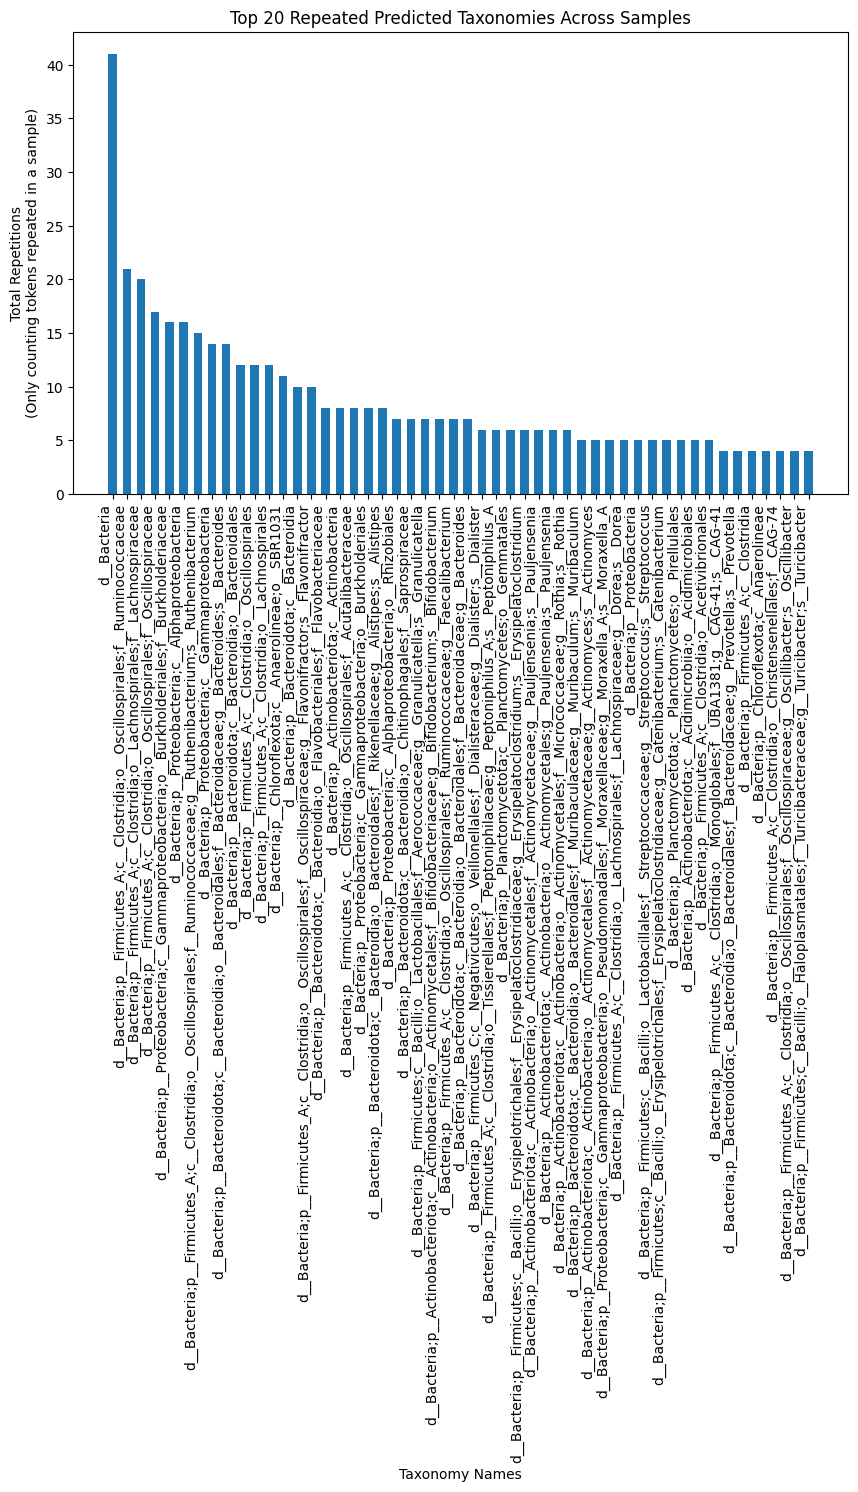

In [122]:
top20 = global_counter.most_common(50)

if not top20:
    print("No tokens to plot.")
else:
    # Unzip the token IDs (tokens) and counts
    tokens, counts = zip(*top20)
    
    # Convert tokens to taxonomy names using id_to_str (fallback to str(token) if missing)
    taxonomy_labels = [id_to_str.get(token, str(token)) for token in tokens]
    
    # Create a list of x-coordinates for the bars
    x_positions = np.arange(len(tokens))
    
    # 2) Create the bar plot using these x-coordinates
    plt.figure(figsize=(10, 6))
    plt.bar(x_positions, counts, width=0.6)
    
    # 3) Set custom x-ticks to display your taxonomy names as labels
    plt.xticks(x_positions, taxonomy_labels, rotation=90, ha='right')
    
    plt.xlabel("Taxonomy Names")
    plt.ylabel("Total Repetitions\n(Only counting tokens repeated in a sample)")
    plt.title("Top 20 Repeated Predicted Taxonomies Across Samples")
    plt.tight_layout()
    plt.show()

In [131]:
902442/len(train_dataset)

0.6143223571889526

In [133]:
20000*0.6

12000.0

/tmp/ipykernel_2315383/4181971150.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


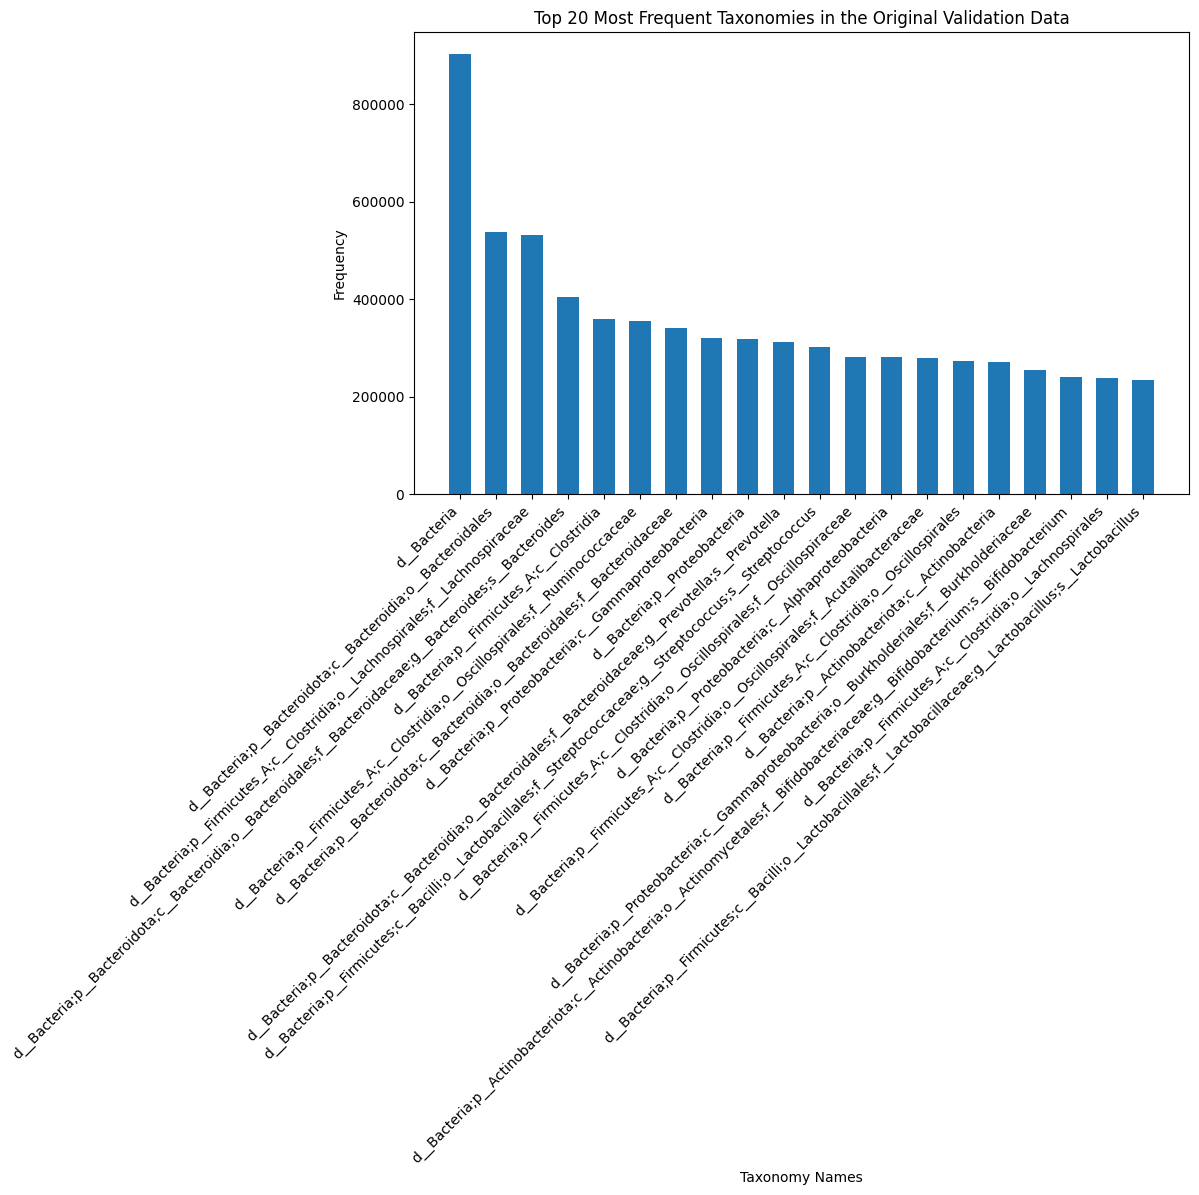

In [126]:
pad_token_id = token_dict["<pad>"]

original_counter = Counter()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    # Assuming original tokens are stored in sample["input_ids"]
    tokens = sample["input_ids"]
    for token in tokens:
        # Skip pad tokens
        if token != pad_token_id:
            original_counter[token] += 1

# Extract the top 20 most repeated tokens.
top20_original = original_counter.most_common(20)


tokens, counts = zip(*top20_original)

# Convert token IDs to taxonomy names using the id_to_str mapping.
taxonomy_labels = [id_to_str.get(token, str(token)) for token in tokens]

# Create x positions for each bar.
x_positions = np.arange(len(tokens))

# Plot the histogram.
plt.figure(figsize=(10, 6))
plt.bar(x_positions, counts, width=0.6)
plt.xticks(x_positions, taxonomy_labels, rotation=45, ha='right')
plt.xlabel("Taxonomy Names")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Taxonomies in the Original Validation Data")
plt.tight_layout()
plt.show()



In [134]:
pad_token_id = token_dict["<pad>"]

# Global counter: counts 1 for each sample where a token is repeated.
global_repeated_counter = Counter()
samples_with_duplicates = 0

# Optional: record per-sample duplicate info.
sample_duplicates_info = []

for idx, sample in enumerate(train_dataset):
    tokens = sample["input_ids"]
    # Remove pad tokens from counting.
    tokens = [token for token in tokens if token != pad_token_id]
    
    sample_counter = Counter(tokens)
    # Filter to keep only repeated tokens.
    duplicates = {token: count for token, count in sample_counter.items() if count > 1}
    
    if duplicates:
        samples_with_duplicates += 1
        # For each duplicate in this sample, count it only once.
        for token in duplicates.keys():
            global_repeated_counter[token] += 1

    sample_duplicates_info.append({
        "sample_idx": idx,
        "duplicates": duplicates
    })

print(f"Out of {len(train_dataset)} samples, {samples_with_duplicates} contain repeated taxonomies.")

# Plot histogram for top 20 tokens that are repeated in a sample (counted once per sample)
top20 = global_repeated_counter.most_common(20)
if top20:
    tokens, counts = zip(*top20)
    taxonomy_labels = [id_to_str.get(token, str(token)) for token in tokens]
    x_positions = np.arange(len(tokens))
    
    plt.figure(figsize=(10, 6))
    plt.bar(x_positions, counts, width=0.6)
    plt.xticks(x_positions, taxonomy_labels, rotation=45, ha='right')
    plt.xlabel("Taxonomy Names")
    plt.ylabel("Number of Samples with Duplicate")
    plt.title("Top 20 Repeated Taxonomies in Training Data (Counted Once per Sample)")
    plt.tight_layout()
    plt.show()
else:
    print("No duplicates found in training samples.")


Out of 1469004 samples, 0 contain repeated taxonomies.
No duplicates found in training samples.


In [135]:
tokens

[5960,
 6294,
 6362,
 6292,
 6765,
 5626,
 5623,
 5973,
 5615,
 5921,
 5604,
 6296,
 6246,
 6156,
 6079,
 6764,
 5975,
 715]

In [14]:
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs"
epoch_to_test = 50  # we want the model at epoch 50
sample_index = 10   # we want to inspect sample 10 from the validation dataset

# Construct the checkpoint path for epoch 50.
# We assume the folder is named like "checkpoint-epoch50"
checkpoint_name = f"checkpoint-epoch{epoch_to_test}"
checkpoint_path = os.path.join(model_folder, checkpoint_name)

# ---------------------------
# Load the model from checkpoint for epoch 50
# ---------------------------
from transformers import BertForMaskedLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained(checkpoint_path)
model.to(device)
model.eval()
print(f"Loaded model from: {checkpoint_path}")

Loaded model from: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/checkpoint-epoch50


In [15]:

# Build inverse dictionary for printing (if not already available)
id_to_str = {v: k for k, v in token_dict.items()}

# Retrieve a specific sample from the validation dataset; sample_index = 10 in this example.
sample_index = 10
sample = val_dataset[sample_index]
original_ids = sample["input_ids"]

# Apply random masking on the sample.
# Define special_ids to exclude, e.g., <pad> and <mask>
special_ids = { token_dict["<pad>"], token_dict["<mask>"] }
masked_ids, masked_positions, original_tokens = randomly_mask_sequence(
    original_ids,
    mask_token_id=token_dict["<mask>"],
    vocab_size=len(token_dict),
    mlm_probability=0.15,
    mask_replace_prob=0.8,
    random_replace_prob=0.1,
    special_ids=special_ids
)

# Run the model inference on the masked sample.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
input_ids_tensor = torch.tensor([masked_ids], dtype=torch.long, device=device)
attention_mask_tensor = (input_ids_tensor != token_dict["<pad>"]).long()
with torch.no_grad():
    outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
    logits = outputs.logits  # shape: [1, seq_len, vocab_size]

# Print the complete sequence vertically.
print("\n=== Detailed Sample Inspection (Sample index {}) ===".format(sample_index))
for pos in range(len(original_ids)):
    # Get the original token
    orig_tok = original_ids[pos]
    orig_str = id_to_str.get(orig_tok, "<unk>")
    
    # Check if this position was masked
    if pos in masked_positions:
        # Retrieve model predictions for this position.
        token_logits = torch.tensor(logits[0, pos])
        topk = torch.topk(token_logits, k=5)
        top_ids = topk.indices.tolist()
        top_values = topk.values.tolist()
        top_preds = [id_to_str.get(tid, "<unk>") for tid in top_ids]
        
        print(f"Position {pos}:")
        print(f"  Original Token: {orig_tok} => {orig_str}  [MASKED]")
        print("  Top-5 Predictions:")
        for rank, (pred_id, score, pred_str) in enumerate(zip(top_ids, top_values, top_preds), start=1):
            print(f"    {rank}. {pred_id} => {pred_str}, logit: {score:.2f}")
    else:
        print(f"Position {pos}: {orig_tok} => {orig_str}")
        if orig_str == "<pad>":
                  break
    



=== Detailed Sample Inspection (Sample index 10) ===
Position 0: 2607 => d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium
Position 1: 6481 => d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Helcococcaceae;g__Finegoldia;s__Finegoldia
Position 2: 715 => d__Bacteria
Position 3: 3128 => d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella
Position 4: 6479 => d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Helcococcaceae;g__Anaerococcus;s__Anaerococcus
Position 5: 5734 => d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus
Position 6: 6514 => d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus_A;s__Peptoniphilus_A
Position 7:
  Original Token: 5884 => d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g_

/tmp/ipykernel_2315383/1231991973.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_logits = torch.tensor(logits[0, pos])


# Tree distances metric

In [18]:

def taxonomy_distance(tax1, tax2):
	ranks1 = tax1.split(";")
	ranks2 = tax2.split(";")
	prefix_len = 0
	for a, b in zip(ranks1, ranks2):
		if a == b:
			prefix_len += 1
		else:
			break
	return (len(ranks1) - prefix_len) + (len(ranks2) - prefix_len)

def compute_tax_distance_metric(examples_list, token_dict):
    """
    For each masked token in `examples_list`, compute the tree distance
    between the real taxonomy and the model's top-1 predicted taxonomy.
    
    Returns a dictionary with:
       - "mean_distance": mean distance across all masked tokens
       - "std_distance":  std dev of the distance
       - "total_masked":  total count of masked tokens
    """

    # Build inverse dictionary: token ID -> taxonomy string
    id_to_str = {v: k for k, v in token_dict.items()}
    
    distances = []
    
    total_masked = 0
    for sample in examples_list:
        masked_positions = sample["masked_positions"]
        logits_matrix = sample["logits"]  # shape [seq_len, vocab_size]
        original_tokens = sample["original_tokens"]  # ground truth for each masked position
        # Convert to torch tensor for easy argmax
        import torch
        logits_tensor = torch.tensor(logits_matrix)
        
        for pos in masked_positions:
            real_id = original_tokens[pos]
            if real_id is None:
                continue
            total_masked += 1
            
            # Real taxonomy
            real_tax = id_to_str.get(real_id, "<unk>")
            
            # Predicted taxonomy
            pred_id = torch.argmax(logits_tensor[pos]).item()
            pred_tax = id_to_str.get(pred_id, "<unk>")
            
            dist = taxonomy_distance(real_tax, pred_tax)
            distances.append(dist)
    
    if not distances:
        return {
            "mean_distance": 0.0,
            "std_distance": 0.0,
            "total_masked": 0
        }
    else:
        mean_dist = float(np.mean(distances))
        std_dist  = float(np.std(distances))
        return {
            "mean_distance": mean_dist,
            "std_distance": std_dist,
            "total_masked": total_masked
        }


In [19]:
def get_checkpoint_data_with_all_metrics(
    model_folder,
    val_dataset,
    token_dict,
    device,
    n=1000,
    mlm_probability=0.15,
    batch_size=512,
    seed=123    
):
    """
    For each checkpoint in model_folder (named like 'checkpoint-epochX'):
      1. Load the model
      2. Evaluate it on 'n' random validation samples using test_model_on_val_samples_batched
      3. Compute:
         - top-1 masked accuracy
         - contextual overlap fraction (compute_repetition_metric)
         - top-1 repetition fraction (compute_top1_repetition_metric)
         - taxonomy distance metric (compute_tax_distance_metric)
    Returns a dictionary with:
      {
        "epochs": [...],
        "accuracy": [...],
        "rep_context_mean": [...],
        "rep_context_std": [...],
        "rep_top_mean": [...],
        "rep_top_std": [...],
        "dist_mean": [...],
        "dist_std": [...],
      }
    """
    # List all checkpoint subfolders
    checkpoints = [d for d in os.listdir(model_folder) if d.startswith("checkpoint-epoch")]
    # Sort them by epoch
    checkpoints.sort(key=get_epoch_from_dir)

    # Prepare lists for each metric
    epochs = []
    accuracies = []
    
    rep_context_mean = []
    rep_context_std  = []
    
    rep_top_mean = []
    rep_top_std  = []
    
    dist_mean = []
    dist_std  = []

    for d in checkpoints:
        ep = get_epoch_from_dir(d)
        checkpoint_path = os.path.join(model_folder, d)
        print(f"\n=== Loading checkpoint at epoch {ep}: {checkpoint_path} ===")
        
        # Load model
        model_ckpt = BertForMaskedLM.from_pretrained(checkpoint_path)
        model_ckpt.to(device)
        
        # Evaluate top-1 masked accuracy in a batched manner
        accuracy, examples_list = test_model_on_val_samples_batched(
            model=model_ckpt,
            val_dataset=val_dataset,
            token_dict=token_dict,
            device=device,
            n=n,
            mlm_probability=mlm_probability,
            batch_size=batch_size,
            seed=seed
        )
        
        # 1) Compute contextual overlap fraction
        rep_metrics = compute_repetition_metric(examples_list, token_dict)
        
        # 2) Compute top-1 repetition fraction
        rep_top_metric = compute_top1_repetition_metric(examples_list)
        
        # 3) Compute the taxonomy distance metric
        dist_metrics = compute_tax_distance_metric(examples_list, token_dict)
        
        # Append epoch
        epochs.append(ep)
        # Append accuracy
        accuracies.append(accuracy)
        
        rep_context_mean.append(rep_metrics["mean_fraction"])
        rep_context_std.append(rep_metrics["std_fraction"])
        
        rep_top_mean.append(rep_top_metric["mean_repetition"])
        rep_top_std.append(rep_top_metric["std_repetition"])
        
        dist_mean.append(dist_metrics["mean_distance"])
        dist_std.append(dist_metrics["std_distance"])
        
        print(f"Epoch {ep}: accuracy={accuracy:.4f}, "
              f"context_rep={rep_metrics['mean_fraction']:.4f}, "
              f"top1_rep={rep_top_metric['mean_repetition']:.4f}, "
              f"distance={dist_metrics['mean_distance']:.4f}")
    
    # Return a dictionary with all metric arrays
    results_dict = {
        "epochs": epochs,
        "accuracy": accuracies,
        "rep_context_mean": rep_context_mean,
        "rep_context_std": rep_context_std,
        "rep_top_mean": rep_top_mean,
        "rep_top_std": rep_top_std,
        "dist_mean": dist_mean,
        "dist_std": dist_std
    }
    return results_dict


In [20]:
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results_1 = get_checkpoint_data_with_all_metrics(
    model_folder=model_folder,
    val_dataset=val_dataset,
    token_dict=token_dict,
    device=device,
    n=100,           
    mlm_probability=0.15,
    batch_size=512,
    seed=123  
)


model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs"

results_2 = get_checkpoint_data_with_all_metrics(
    model_folder=model_folder,
    val_dataset=val_dataset,
    token_dict=token_dict,
    device=device,
    n=100,           
    mlm_probability=0.15,
    batch_size=512,
    seed=123  
)






=== Loading checkpoint at epoch 1: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch1 ===
Epoch 1: accuracy=0.1715, context_rep=0.1295, top1_rep=0.4225, distance=6.1180

=== Loading checkpoint at epoch 5: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch5 ===
Epoch 5: accuracy=0.2004, context_rep=0.0394, top1_rep=0.4240, distance=5.8174

=== Loading checkpoint at epoch 10: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch10 ===
Epoch 10: accuracy=0.2227, context_rep=0.0238, top1_rep=0.4170, distance=5.7305

=== Loading checkpoint at epoch 15: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/checkpoint-epoch15 ===
Epoch 15: accuracy=0.2160, context_rep=0.0216,

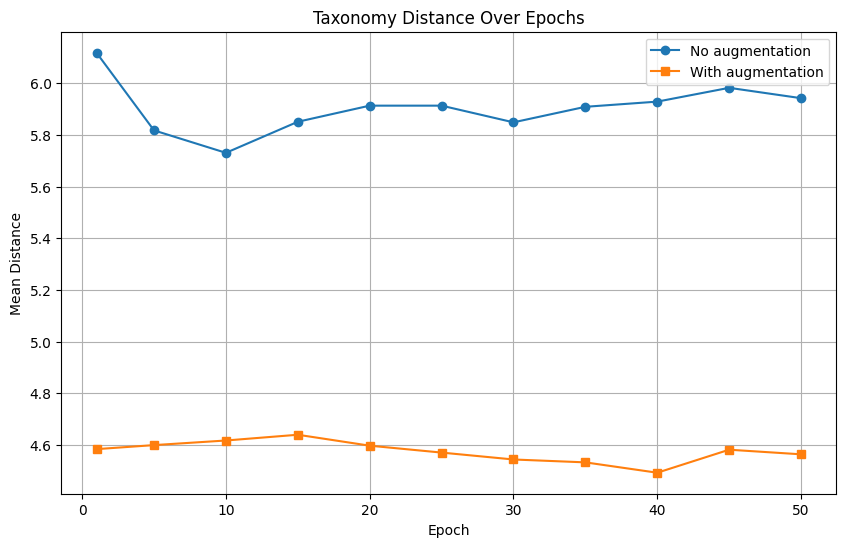

In [21]:

plt.figure(figsize=(10,6))
plt.plot(results_1["epochs"], results_1["dist_mean"], marker='o', label="No augmentation")
plt.plot(results_2["epochs"], results_2["dist_mean"], marker='s', label="With augmentation")
plt.xlabel("Epoch")
plt.ylabel("Mean Distance")
plt.title("Taxonomy Distance Over Epochs")
plt.grid(True)
plt.legend()
plt.show()


In [87]:
real_tax = "d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Helcococcaceae;g__Finegoldia;s__Finegoldia"
pred_tax = "d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Bacteroidaceae;g__Prevotella"



dist = taxonomy_distance(real_tax, pred_tax)
print("Distance =", dist)  # Distance = 2


Distance = 5


In [85]:
(7-1)+(7-1) 

12

In [89]:
(7-4)+(6-4) 

5

# testing collator

In [171]:
import torch
from collections import Counter
from transformers import BatchEncoding
from transformers import DataCollatorForLanguageModeling, BatchEncoding
from dataloaders import dataset_to_hf_dataset, TaxonomyPreCollator, create_taxonomy_data_collator

In [177]:

def create_taxonomy_data_collator(token_dict, mlm_probability=0.15, mask_replace_prob=0.8):
    pre_collator = TaxonomyPreCollator(token_dict)
    mlm_collator = DataCollatorForLanguageModeling(
        tokenizer=pre_collator, 
        mlm=True, 
        mlm_probability=mlm_probability,
        mask_replace_prob=mask_replace_prob,
        random_replace_prob=0
    )
    return mlm_collator


In [178]:

num_samples_to_test = 10000

samples = [train_dataset[i] for i in range(num_samples_to_test)]
collator = create_taxonomy_data_collator(token_dict,  mask_replace_prob=1)

batch = collator(samples)

# Check for duplicated tokens and duplicated labels in masked input_ids
duplicated_tokens_samples = 0
duplicated_labels_samples = 0

for idx, sample_input_ids in enumerate(batch["input_ids"]):
    # Remove pad tokens
    tokens_no_pad = [t.item() for t in sample_input_ids if t.item() != token_dict["<pad>"]]
    attention_mask = batch["attention_mask"][idx][:len(tokens_no_pad)]
    training_labels = batch["labels"][idx][:len(tokens_no_pad)]

    # Check for duplicated tokens (excluding masks which are expected duplicates)
    token_counts = Counter(tokens_no_pad)
    token_duplicates = {token: count for token, count in token_counts.items() 
                        if count > 1 and token != token_dict["<mask>"]}

    if token_duplicates:
        duplicated_tokens_samples += 1
        print(f"Sample {idx} duplicated tokens (excluding masks): {token_duplicates}")

    # Check for duplicated labels, ignoring -100
    labels_no_ignore = [label.item() for label in training_labels if label.item() != -100]
    label_counts = Counter(labels_no_ignore)
    label_duplicates = {label: count for label, count in label_counts.items() if count > 1}

    if label_duplicates:
        duplicated_labels_samples += 1
        print(f"Sample {idx} duplicated labels (excluding -100): {label_duplicates}")

if duplicated_tokens_samples == 0:
    print("✅ No unexpected duplicated tokens (excluding masks) found.")
else:
    print(f"❌ Found {duplicated_tokens_samples} samples with duplicated tokens (excluding masks).")

if duplicated_labels_samples == 0:
    print("✅ No duplicated labels (excluding -100) found.")
else:
    print(f"❌ Found {duplicated_labels_samples} samples with duplicated labels (excluding -100).")

✅ No unexpected duplicated tokens (excluding masks) found.
✅ No duplicated labels (excluding -100) found.


In [156]:
# Count top-1 predictions on masked tokens from a subset of samples (e.g., 1000)
top1_predictions = []
for ex in examples_list:
    for pos in ex["masked_positions"]:
        logits = torch.tensor(ex["logits"][pos])
        top1 = torch.argmax(logits).item()
        top1_predictions.append(top1)

top_preds_counter = Counter(top1_predictions)
most_common_preds = top_preds_counter.most_common(10)
for token_id, freq in most_common_preds:
    print(f"Token {token_id} ({id_to_str.get(token_id, 'UNK')}): predicted {freq} times")

Token 715 (d__Bacteria): predicted 166 times
Token 6079 (d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae): predicted 88 times
Token 6314 (d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae): predicted 87 times
Token 9156 (d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria): predicted 79 times
Token 8144 (d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria): predicted 70 times
Token 9263 (d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae): predicted 66 times
Token 6288 (d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae): predicted 65 times
Token 6358 (d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruthenibacterium;s__Ruthenibacterium): predicted 54 times
Token 4254 (d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__SBR1031): predicted 54 times
Token 3112 (d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Ba